In [7]:
%env METAL_XCODE=1
%env DISABLE_COMPILER_CACHE=1

env: METAL_XCODE=1
env: DISABLE_COMPILER_CACHE=1


In [8]:
# first let's import the necessary libraries
import numpy as np # numpy is the main library we will use for numerical computations
import matplotlib.pyplot as plt # matplotlib is the main library we will use for plotting

# the only two libraries we will need.
from tinygrad import Tensor, dtypes # Autograd library
from tinygrad.nn.optim import Adam
from tinygrad import TinyJit

In [13]:
def get_inverse_batched(matrices):

    a = matrices[:,0,0]
    b = matrices[:,0,1]
    c = matrices[:,1,0]
    d = matrices[:,1,1]    

    det = a*d - b*c    

    d_new = d.unsqueeze(1)
    b_new = -b.unsqueeze(1)
    a_new = a.unsqueeze(1)
    c_new = -c.unsqueeze(1)

    top = d_new.cat(b_new, dim=1).unsqueeze(1)
    bottom = c_new.cat(a_new, dim=1).unsqueeze(1)

    inverse = top.stack(bottom, dim=2).reshape(-1,2,2) 
    inverse = inverse * (1.0 / det).unsqueeze(1).unsqueeze(1)

    return inverse, det

In [14]:
def generate_splat(coordinates, colors, scale_x, scale_y, rotation, img_size):
    kernel_size = img_size[0]
        
    W = img_size[0] # width of the image
    H = img_size[1] # height of the image
    batch_size = colors.shape[0] # number of Gaussians defined above

    scale = scale_x.stack(scale_y, dim=1) # stack the two scales together
    scale = scale.reshape(batch_size, 2)
    rotation = rotation.reshape(batch_size)

    cos_rot = rotation.cos()
    sin_rot = rotation.sin()

    top = cos_rot.stack(-sin_rot, dim=1)
    bottom = sin_rot.stack(cos_rot, dim=1)
    R = top.stack(bottom, dim=2).reshape(batch_size, 2, 2)

    S = Tensor.eye(2).unsqueeze(0) * scale.unsqueeze(1)
    covariance = R @ S @ S @ R.transpose(-1,-2)

    inv_covariance, covariance_det = get_inverse_batched(covariance)

    x = np.linspace(-5, 5, kernel_size)
    y = np.linspace(-5, 5, kernel_size)
    yy, xx = Tensor(np.meshgrid(x, y))
    yy = yy.expand(batch_size, -1, -1)
    
    xx = xx.expand(batch_size, -1, -1)    

    xx = xx + coordinates[:,0].unsqueeze(1).unsqueeze(1) * 5
    yy = yy + coordinates[:,1].unsqueeze(1).unsqueeze(1) * 5

    xy = xx.stack(yy, dim=-1)
    z = Tensor.einsum('bxyi,bij,bxyj->bxy', xy, -0.5 * inv_covariance, xy)

    kernel = z.exp() / np.pi * covariance_det.sqrt().view(batch_size, 1, 1)
    kernel_max = kernel.max(axis=(1,2), keepdim=True) + 1e-6 # avoid division by zero
    kernel_norm = kernel / kernel_max 

    kernel_rgb = kernel_norm.unsqueeze(1).expand(-1, 3, -1, -1)
    rgb_values_reshaped = colors.unsqueeze(1).unsqueeze(1).permute(0,3,1,2)

    final_image_layers = rgb_values_reshaped * kernel_rgb    

    final_image = final_image_layers.sum(axis=0)

    final_image = final_image.clamp(0, 1)
    final_image = final_image.permute(1,2,0)

    return final_image

In [15]:
def create_window(window_size, channel):

    def gaussian(window_size, sigma):
        gauss = Tensor([-(x - window_size//2)**2/float(2*sigma**2) for x in range(window_size)])
        gauss = gauss.exp()
        # print(gauss.numpy())
        return gauss / gauss.sum()
    
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    # print(_1D_window.numpy())

    _2D_window = _1D_window @ _1D_window.transpose(1,0)
    # print(_2D_window.numpy())

    window = _2D_window.unsqueeze(0).expand(channel, 1, window_size, window_size).contiguous()    

    # print("WINDOW", window.numpy())
    return window

In [16]:
def ssim(img1, img2, window_size=11, size_average=True):

    (_,_,channel) = img1.shape

    img1 = img1.unsqueeze(0).permute(0,3,1,2)
    img2 = img2.unsqueeze(0).permute(0,3,1,2)

    #parameters for ssim --> https://en.wikipedia.org/wiki/Structural_similarity_index_measure
    C1 = 0.01**2
    C2 = 0.03**3

    window = create_window(window_size, channel)

    mux = (img1).conv2d(window, stride=1, padding=window_size//2, groups=channel)
    muy = (img2).conv2d(window, stride=1, padding=window_size//2, groups=channel)
    mu_x_sq = mux * mux
    mu_y_sq = muy * muy
    mu_xy = mux * muy

    sigma_x_sq = (img1 * img1).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_x_sq
    sigma_y_sq = (img2 * img2).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_y_sq
    sigma_xy = (img1 * img2).conv2d(window, stride=1, padding=window_size//2, groups=channel) - mu_xy

    SSIM_numerator = (2 * mu_xy + C1) * (2 * sigma_xy + C2)
    SSIM_denominator = (mu_x_sq + mu_y_sq + C1) * (sigma_x_sq + sigma_y_sq + C2)

    # print(SSIM_numerator.numpy())
    # print(SSIM_denominator.numpy())

    ssim_map = SSIM_numerator / SSIM_denominator

    # print(ssim_map.numpy())

    ret = ((1-ssim_map)/2).clamp(0, 1)  
    # print(ret.numpy())

    return ret

def d_ssim_loss(img1, img2, window_size=11, size_average=True):
    return ssim(img1, img2, window_size, size_average).mean()

def l1_loss(img1, img2):
    return (img1 - img2).abs().mean()

def combined_loss(img1, img2, lambda_param=0.84):   
    # print("l1_loss", l1_loss(img1, img2).numpy())
    # print("d_ssim_loss", d_ssim_loss(img1, img2).numpy()) 
    return (1 - lambda_param) * l1_loss(img1, img2) + lambda_param * d_ssim_loss(img1, img2)


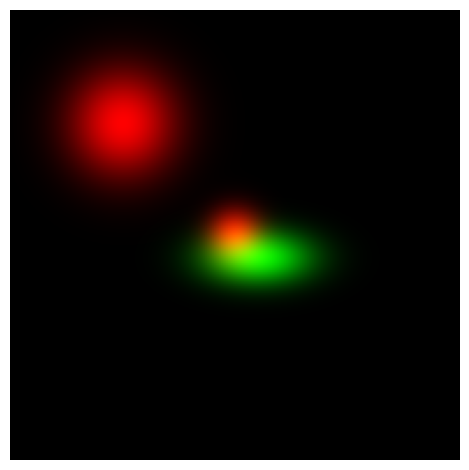

In [17]:
img_size = (256,256,3) # size of the image

kernel_size = 105 # dimension of the kernel -> it is the quality of the Gaussian
scale_x = Tensor([1.0,2.0,2.0]) # scale of the Gaussian in x direction
scale_y = Tensor([1.0,2.0,1.0]) # scale of the Gaussian in y direction
scale_x = scale_x / (img_size[0] / kernel_size)
scale_y = scale_y / (img_size[1] / kernel_size)
rotation = Tensor([0.0, 0.0, -(np.pi/2)]) # rotation of the Gaussian in radians
coordinates = Tensor([(0,0), (0.5,0.5), (-0.1, -0.1)]) # coordinates of the Gaussian
colors = Tensor([(1,0,0), (1,0,0), (0,1,0)]) # color of the Gaussian
W = img_size[0] # width of the image
H = img_size[1] # height of the image

splatted = generate_splat(coordinates, colors, scale_x, scale_y, rotation, img_size)

plt.imshow(splatted.numpy())
plt.axis("off")
plt.tight_layout()
plt.show()

In [20]:
KERNEL_SIZE = 101
image_size = [256, 256, 3]
primary_samples = 1000
backup_samples = 3000
num_epochs = 2001
densification_interval = 300
learning_rate = 0.01
image_file_name = "../image.png"
display_interval = 100
gradient_threshold = 0.0002
gaussian_threshold = 0.075
display_loss = True

In [21]:
from PIL import Image

num_samples = primary_samples + backup_samples
indices_tensor = Tensor([1,2,3,4], dtype=dtypes.int32)

image_path = image_file_name
original_image = Image.open(image_path)
original_image = original_image.resize((image_size[0],image_size[0]))
original_image = original_image.convert('RGB')
original_array = np.array(original_image)
original_array = original_array / 255.0
width, height, _ = original_array.shape

image_array = original_array

target_tensor = Tensor(image_array, dtype=dtypes.float32)

# Creating pixel values
coords_tensor = Tensor.rand(num_samples, 2, dtype=dtypes.float32, requires_grad=True)
center_values = Tensor([0.5, 0.5], dtype=dtypes.float32, requires_grad=False)
coords_tensor = (coords_tensor - center_values) * 2
pixel_coords_tensor = coords_tensor.atanh()

# integer coordinates
coords_tensor_integers = (coords_tensor + 1) * 0.5 * image_size[0]
coords_tensor_integers = coords_tensor_integers.int()

# creating color values picked from the above pixels coordinates
color_values = image_array[coords_tensor_integers[:, 0].numpy(), coords_tensor_integers[:, 1].numpy()]
color_values_tensor = Tensor(color_values, dtype=dtypes.float32, requires_grad=True) - 1e-6
# print(color_values_tensor[indices_tensor].numpy())
color_values_tensor = (color_values_tensor.div(1 - color_values_tensor)).log()

# randomly initialize the scales of the Gaussians
scale_values_tensor = Tensor.rand(num_samples, 2, dtype=dtypes.float32, requires_grad=True)
scale_values_tensor = scale_values_tensor * (KERNEL_SIZE / image_size[0])
scale_values_tensor = (scale_values_tensor.div(1 - scale_values_tensor)).log()

# randomly initialize the alpha values
alpha_values_tensor = Tensor.rand(num_samples, 1, dtype=dtypes.float32, requires_grad=True)
alpha_values_tensor = (alpha_values_tensor.div(1-alpha_values_tensor)).log()

# randomly initialize the rotation values
rotation_values_tensor = (2 * Tensor.rand(num_samples, 1, dtype=dtypes.float32, requires_grad=True) - 1).atanh()

W_values = scale_values_tensor.cat(rotation_values_tensor, alpha_values_tensor, color_values_tensor, pixel_coords_tensor, dim=1)

# print(W_values[indices_tensor, :].numpy())
# print(W_values[:, :].shape)

current_marker = primary_samples

optimizer = Adam([W_values], lr=0.01)
loss_history = []


print("W_values", W_values.numpy().shape)

W_values (3000, 9)


In [22]:
with Tensor.train():    

    for epoch in range(num_epochs):

        output = W_values[:current_marker, :]  

        batch_size = output.shape[0]
        # print("batch_size", batch_size)
        scale = output[:,0:2].sigmoid()
        rotation = output[:,2].tanh() * np.pi /2
        alpha = output[:,3].sigmoid()
        color = output[:,4:7].sigmoid()        
        coords = output[:,7:9].tanh()          

        colors_with_alpha = color * (alpha.view(batch_size, 1))     

        # I think I just need to change the order here! and then it should magically work         

        g_tensor_batch = generate_splat(coords, colors_with_alpha, scale[:,0], scale[:,1], rotation, image_size)        
        loss = combined_loss(g_tensor_batch, target_tensor, lambda_param=0.5)        

        optimizer.zero_grad()        

        loss.backward()

        optimizer.step()

        loss_history.append(loss.item())

        if epoch % densification_interval == 0 and epoch > 0:
            print("Densifying...")

            gradients = W_values.grad[:current_marker,7:9].numpy()
            gradient_norms = np.linalg.norm(gradients, axis=1, ord=2)
            print("GRAD SHAPE", gradient_norms.shape)
            gaussians = W_values.grad[:current_marker, 0:2].numpy()
            gaussian_norms = np.linalg.norm(gradients, axis=1, ord=2)
            print("GAUS SHAPE", gaussian_norms.shape)
            
            # here we sort the values in descending order and we get the index of the values in the sorted_grads_indices            
            sorted_grads_indices = np.argsort(gradient_norms)[::-1].reshape(-1, 1)            
            # here we get the sorted values
            sorted_grads = gradient_norms[sorted_grads_indices].reshape(-1,1)            

            # here we sort the values in descending order and we get the index of the values in the sorted_grads_indices
            sorted_gaussians_indices = np.argsort(gaussian_norms)[::-1].reshape(-1, 1)
            # here we get the sorted values        
            sorted_gaussians = gaussian_norms[sorted_gaussians_indices].reshape(-1,1)            

            large_gradient_mask = (sorted_grads > gradient_threshold)
            small_gradient_mask = (sorted_grads <= gradient_threshold)      

            large_gradient_indices = sorted_grads_indices[large_gradient_mask]
            small_gradient_indices = sorted_grads_indices[small_gradient_mask]

            print("LGI", large_gradient_indices.shape)
            print("SGI", small_gradient_indices.shape)

            large_gaussian_mask = (sorted_gaussians > gaussian_threshold)
            large_gaussian_indices = sorted_gaussians_indices[large_gaussian_mask]

            common_indices_mask = np.isin(large_gradient_indices, large_gaussian_indices)                        
            common_indices = large_gradient_indices[common_indices_mask]            
            print("common_indices", common_indices.shape)
            
            distinct_indices = large_gradient_indices[~common_indices_mask]
            print("distinct_indices", distinct_indices.shape)            

            common_indices_tensor = Tensor(common_indices.flatten(), dtype=dtypes.int32, requires_grad=False)
            distinct_indices_tensor = Tensor(distinct_indices.flatten(), dtype=dtypes.int32, requires_grad=False)
            small_gradient_indices_tensor = Tensor(small_gradient_indices.flatten(), dtype=dtypes.int32, requires_grad=False)

            print(f"Number of splitted points: {len(common_indices)}")
            print(f"Number of cloned points: {len(distinct_indices)}")

            # disable grad for the parameters because it is not supported for set index
            W_values.requires_grad = False

            if len(common_indices) > 0:
                print(f"Number of splitted points: {len(common_indices)}")                

                start_index = current_marker + 1
                end_index = current_marker + 1 + len(common_indices)

                W_values[start_index:end_index, :] = W_values[common_indices_tensor, :]

                scale_reduction_factor = 1.6
                W_values[start_index:end_index, 0:2].div(scale_reduction_factor)
                W_values[common_indices_tensor, 0:2].div(scale_reduction_factor)

                current_marker = end_index               


            if len(distinct_indices) > 0:
                print(f"Number of cloned points: {len(distinct_indices)}")

                start_index = current_marker + 1
                end_index = current_marker + 1 + len(distinct_indices)

                W_values[start_index:end_index, :] = W_values[distinct_indices_tensor, :]

                positional_gradients = W_values[distinct_indices_tensor, 7:9].numpy()
                gradient_magnitude = np.linalg.norm(positional_gradients, axis=1, ord=2)
                normalized_gradients = positional_gradients / gradient_magnitude.reshape(-1, 1)
                normalized_gradients_tensor = Tensor(normalized_gradients, dtype=dtypes.float32, requires_grad=False)

                step_size = 0.1

                W_values[start_index:end_index, 7:9] = W_values[start_index:end_index, 7:9] + normalized_gradients_tensor * step_size

                current_marker = end_index

            # re enable grad for the parameters
            W_values.requires_grad = True            

        if epoch % display_interval == 0:
            num_subplots = 3 if display_loss else 2
            fig_size_width = 18 if display_loss else 12

            fig, ax = plt.subplots(1, num_subplots, figsize=(fig_size_width, 6))  # Adjust subplot to 1x3

            generated_array = g_tensor_batch.numpy()

            ax[0].imshow(g_tensor_batch.numpy())
            ax[0].set_title('2D Gaussian Splatting')
            # ax[0].axis('off')

            ax[1].imshow(target_tensor.numpy())
            ax[1].set_title('Ground Truth')
            # ax[1].axis('off')

            if display_loss:
                ax[2].plot(range(epoch + 1), loss_history[:epoch + 1])
                ax[2].set_title('Loss vs. Epochs')
                ax[2].set_xlabel('Epoch')
                ax[2].set_ylabel('Loss')
                ax[2].set_xlim(0, num_epochs)  # Set x-axis limits

            # Display the image
            #plt.show(block=False)
            plt.subplots_adjust(wspace=0.1)  # Adjust this value to your preference
            plt.pause(0.1)  # Brief pause

            img = Image.fromarray((generated_array * 255).astype(np.uint8))            

            plt.clf()  # Clear the current figure
            plt.close()  # Close the current figure

            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, on {len(output)} points") 

KeyboardInterrupt: 